In [163]:
import random
import pandas as pd

# URL 얻기

## /robots.txt

- https://docs.python.org/ko/3/library/urllib.robotparser.html

In [8]:
import urllib.robotparser
rp=urllib.robotparser.RobotFileParser() # 로봇파서 객체 생성
rp.set_url('https://www.joongang.co.kr/robots.txt') # 로봇파서 객체의 속성값 중 url set
rp.read() # 로봇파서 객체의 기능 중 read() 수행
rp.can_fetch("*", "https://www.joongang.co.kr/sitemap.xml" )
# 구문 분석된 robots.txt 파일에 포함된 규칙에 따라, useragent가 url를 가져올 수 있으면 True를 반환합니다.
sitemap_url_list=rp.site_maps()
# robots.txt에서 Sitemap 매개 변수의 내용을 list() 형식으로 반환합니다. 해당 매개 변수가 없거나 robots.txt의 이 매개 변수 항목이 잘못된 문법이면 None을 반환합니다.
sitemap_url_list

['https://www.joongang.co.kr/sitemap/latest-articles',
 'https://www.joongang.co.kr/sitemap/daily-articles',
 'https://www.joongang.co.kr/sitemap/daily-images',
 'https://www.joongang.co.kr/sitemap/sections',
 'https://www.joongang.co.kr/sitemap/etc']

## sitemap.xml -> url

- https://pypi.org/project/xmltodict/
- 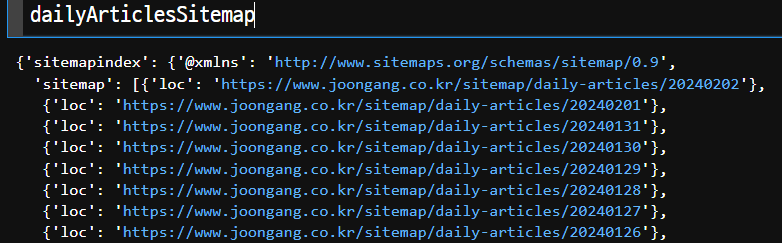

In [11]:
!pip install xmltodict


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
import xmltodict
import requests

## 
# 1. sitemap_url_list에서 1번 인덱스인 daily articles의 url을 요청한다
# 2. 요청결과의 텍스트를 가져온다
# 3. xmltodict 객제를 가지고 그 텍스트를 파싱한다. 
dailyArticlesSitemap=xmltodict.parse(requests.get(sitemap_url_list[1]).text)
# 가져온 결과를 확인해보니 'sitemapindex' -> 'sitemap' 으로 들어가야 url을 가져올 수 있었다.
dailyArticlesSitemap['sitemapindex']['sitemap'][:5]
# 중앙일보 일간기사 사이트맵을 일단위로 구성되어있음 2014년 2월 5일 ~ 오늘

[{'loc': 'https://www.joongang.co.kr/sitemap/daily-articles/20240202'},
 {'loc': 'https://www.joongang.co.kr/sitemap/daily-articles/20240201'},
 {'loc': 'https://www.joongang.co.kr/sitemap/daily-articles/20240131'},
 {'loc': 'https://www.joongang.co.kr/sitemap/daily-articles/20240130'},
 {'loc': 'https://www.joongang.co.kr/sitemap/daily-articles/20240129'}]

In [38]:
## sitemap url 획득
dailyArticleUrl_dict_list=[]

for d in dailyArticlesSitemap['sitemapindex']['sitemap'][:5]: 
    # d.get('loc',None) ## 사이트맵 URL
    ## 사이트맵 URL을 요청하면 XML 형식의 실제 기사 URL이 나옴. 이 XML 형식을 딕셔너리 형식으로 변환해서 받아오기 
    dailyArticleUrl_dict_list.append(xmltodict.parse(requests.get(d.get('loc',None)).text))

# dailyArticleUrl_dict_list[0]

In [39]:
## 실제 기사의 url 획득
dailyArticleUrl_list=[]
for sitemap in dailyArticleUrl_dict_list:
    for url_dict in sitemap['urlset']['url']:
        dailyArticleUrl_list.append(url_dict['loc'])
dailyArticleUrl_list[:10]

['https://www.joongang.co.kr/article/25226514',
 'https://www.joongang.co.kr/article/25226513',
 'https://www.joongang.co.kr/article/25226512',
 'https://www.joongang.co.kr/article/25226511',
 'https://www.joongang.co.kr/article/25226510',
 'https://www.joongang.co.kr/article/25226509',
 'https://www.joongang.co.kr/article/25226508',
 'https://www.joongang.co.kr/article/25226507',
 'https://www.joongang.co.kr/article/25226506',
 'https://www.joongang.co.kr/article/25226505']

In [40]:
print(len(dailyArticleUrl_list)) # 최근 5일치의 기사들 URL모음

1334


In [41]:
requests.get(dailyArticleUrl_list[0]).text[:500]
## html 스타일로 나옴

'<!doctype html>\n<html lang="ko">\n<head>\n<title>美 지역은행 위기 재점화?…상업용 부동산 위기에 주가는 반토막 | 중앙일보</title>\n<meta charset="utf-8"/>\n<meta http-equiv="X-UA-Compatible" content="IE=edge"/>\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>\n<meta http-equiv="Content-Security-Policy" content="upgrade-insecure-requests"/>\n<meta name="viewport" content="width=device-width, initial-scale=1.0">\n<meta name="format-detection" content="telephone=no, address=no, email=no"/>\n<meta name="title" content'

# 데이터 다운로드

## html 페이지 다운로드

In [50]:
%%time
dir='../output/중앙일보일간뉴스_HTMLDOC/'
s=requests.Session() # cpu times와 wall times 보여줌
for url in dailyArticleUrl_list:
    fileName=url.split('/')[-1] # url의 가장 마지막 번호를 파일명으로 사용한다. (예: 25226514)
    response=s.get(url)

    if response.ok:
        with open(dir+fileName+".txt", "w+b") as f:
            f.write(response.text.encode('utf-8'))
    else:
        print("error with url %s" %url)

CPU times: total: 8.66 s
Wall time: 1min 43s


In [46]:
import os
os.getcwd()

'D:\\user\\Desktop\\DataScience_git\\TextAnalysis'

# 반정형(텍스트 등) 데이터 추출

In [59]:
fileName_list=os.listdir('../output/중앙일보일간뉴스_HTMLDOC/')
print(fileName_list[random.randint(0,len(fileName_list))])

25225973.txt


In [60]:
# 파일 불러오기
with open('../output/중앙일보일간뉴스_HTMLDOC/25225973.txt', 'r', encoding='utf-8') as f:
    html_doc=f.read()
print(html_doc[:500])

<!doctype html>
<html lang="ko">
<head>
<title>소진공, 온누리상품권 최대 10% 할인 | 중앙일보</title>
<meta charset="utf-8"/>
<meta http-equiv="X-UA-Compatible" content="IE=edge"/>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>
<meta http-equiv="Content-Security-Policy" content="upgrade-insecure-requests"/>
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<meta name="format-detection" content="telephone=no, address=no, email=no"/>
<meta name="title" content="소진공, 온누리상품권


## 정규표현식 사용

In [98]:
import re
pattern=re.compile('(?<=<title>).+(?=</title>)') ## 전후방 동시탐색
result=pattern.search(html_doc)
print(result[0])

소진공, 온누리상품권 최대 10% 할인 | 중앙일보


## HTML PARSER

In [99]:
print(html_doc) ## 텍스트 형태의 html_document

<!doctype html>
<html lang="ko">
<head>
<title>소진공, 온누리상품권 최대 10% 할인 | 중앙일보</title>
<meta charset="utf-8"/>
<meta http-equiv="X-UA-Compatible" content="IE=edge"/>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8"/>
<meta http-equiv="Content-Security-Policy" content="upgrade-insecure-requests"/>
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<meta name="format-detection" content="telephone=no, address=no, email=no"/>
<meta name="title" content="소진공, 온누리상품권 최대 10% 할인 | 중앙일보" />
<meta name="description" content="중소벤처기업부(장관 오영주)와 소상공인시장진흥공단(이사장 박성효, 이하 소진공)은 다가오는 설 연휴를 맞아 상차림 부담을 줄여주고 전통시장과…"/>
<meta name="news_keywords" content="온누리상품권,소진공,소진공 온누리상품권,카드형 온누리상품권,모바일 온누리상품권" />
<meta name="robots" content="max-image-preview:large">
<meta property="published_date" content="2024-01-31T15:22:00+09:00"/>
<meta property="fb:app_id" content="1011513095546498" />
<meta property="fb:pages" content="306376056509633,155192444524300" />
<meta property="og:type"

In [130]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_doc, 'html.parser')
title = soup.find("meta", property="og:title")['content']
print(title)
date=soup.find("meta", property="published_date")['content']
print(date)
section=soup.find("meta", property="article:section2")['content']
print(section)

소진공, 온누리상품권 최대 10% 할인 | 중앙일보
2024-01-31T15:22:00+09:00
경제


In [156]:
articleBody=soup.find("div", id="article_body").select("p")
articleText=''
for i in range(1,len(articleBody)):
    if i == len(articleBody)-1:
        writerEmail=articleBody[i].text.strip()
    else:
        articleText+=articleBody[i].text.strip()

print(articleText)
print()
print(writerEmail)

중소벤처기업부(장관 오영주)와 소상공인시장진흥공단(이사장 박성효, 이하 소진공)은 다가오는 설 연휴를 맞아 상차림 부담을 줄여주고 전통시장과 상점가 이용을 촉진하기 위해 ‘온누리상품권’ 사용 혜택을 강화한다고 밝혔다.지류 상품권은 5%, 결제의 편의성을 대폭 높인 모바일과 충전식 카드형 상품권은 10% 할인 판매 중이다.또한, 올해부터 개인 월 할인구매 한도금액이 각 50만원 늘어나 최대 200만원까지 구매할 수 있다.지류 상품권은 전국 16개 은행 전 지점에서 구매가능 하며, ‘모바일 온누리상품권(온누리페이)’과 ‘충전식 카드형 온누리상품권’은 앱스토어 및 플레이스토어에서 앱(App)을 다운받은 후 즉시 구매할 수 있다.충전식 카드형 온누리상품권 구매는 모바일 앱에 본인이 보유 중인 신용카드나 체크카드, 계좌 등록 후 사용할 수 있다. 이후에는 언제든 10% 할인된 금액으로 충전할 수 있으며, 온누리상품권 가맹점에서 충전한 카드로 결제하면 된다. 사용 가맹점은 앱에서 지도 및 검색기능으로 손쉽게 찾아볼 수 있다.또한, 선물하기 기능으로 타인에게 충전식 카드형 온누리상품권을 선물할 수 있다. 개인과 기업 모두 사용 가능하며, 기업 구매도 10% 할인 판매 중이다.소진공 박성효 이사장은 “설 연휴 차례상 준비 부담을 덜고자 온누리상품권 혜택을 늘렸다”면서, “올 설 명절은 전통시장과 상점가에서 합리적인 가격으로 장도 보시고, 따뜻한 정과 사람 사는 이야기도 느껴보시기 바란다”고 전했다.

서명수 기자 seo.myongsoo@joongang.co.kr


In [161]:
## html parser 이용하여 제목, 게재일자, 섹션, 본문텍스트, 작성기자 컬럼으로 구성된 데이터 프레임 만들기
titleList=[]
dateList=[]
sectionList=[]
articleTextList=[]
writerEmailList=[]

fileName_list=os.listdir('../output/중앙일보일간뉴스_HTMLDOC/')
for n in range(len(fileName_list)):
    with open('../output/중앙일보일간뉴스_HTMLDOC/'+fileName_list[i], 'r', encoding='utf-8') as f:
        html_doc=f.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    title = soup.find("meta", property="og:title")['content']
    date=soup.find("meta", property="published_date")['content']
    section=soup.find("meta", property="article:section2")['content']
    articleBody=soup.find("div", id="article_body").select("p")
    articleText=''
    for i in range(1,len(articleBody)):
        if i == len(articleBody)-1:
            writerEmail=articleBody[i].text.strip()
        else:
            articleText+=articleBody[i].text.strip()
    titleList.append(title)
    dateList.append(date)
    sectionList.append(section)
    articleTextList.append(articleText)
    writerEmailList.append(writerEmail)
    print(f'{n}번째 작업 완료')

dailyArticle_df=pd.DataFrame({'title':titleList, 'date':dateList, 'section':sectionList,
                             'artice_text':articleTextList, 'writer_email':writerEmailList})
display(dailyArticle_df.sample(5))

0번째 작업 완료
1번째 작업 완료
2번째 작업 완료
3번째 작업 완료
4번째 작업 완료
5번째 작업 완료
6번째 작업 완료
7번째 작업 완료
8번째 작업 완료
9번째 작업 완료
10번째 작업 완료
11번째 작업 완료
12번째 작업 완료
13번째 작업 완료
14번째 작업 완료
15번째 작업 완료
16번째 작업 완료
17번째 작업 완료
18번째 작업 완료
19번째 작업 완료
20번째 작업 완료
21번째 작업 완료
22번째 작업 완료
23번째 작업 완료
24번째 작업 완료
25번째 작업 완료
26번째 작업 완료
27번째 작업 완료
28번째 작업 완료
29번째 작업 완료
30번째 작업 완료
31번째 작업 완료
32번째 작업 완료
33번째 작업 완료
34번째 작업 완료
35번째 작업 완료
36번째 작업 완료
37번째 작업 완료
38번째 작업 완료
39번째 작업 완료
40번째 작업 완료
41번째 작업 완료
42번째 작업 완료
43번째 작업 완료
44번째 작업 완료
45번째 작업 완료
46번째 작업 완료
47번째 작업 완료
48번째 작업 완료
49번째 작업 완료
50번째 작업 완료
51번째 작업 완료
52번째 작업 완료
53번째 작업 완료
54번째 작업 완료
55번째 작업 완료
56번째 작업 완료
57번째 작업 완료
58번째 작업 완료
59번째 작업 완료
60번째 작업 완료
61번째 작업 완료
62번째 작업 완료
63번째 작업 완료
64번째 작업 완료
65번째 작업 완료
66번째 작업 완료
67번째 작업 완료
68번째 작업 완료
69번째 작업 완료
70번째 작업 완료
71번째 작업 완료
72번째 작업 완료
73번째 작업 완료
74번째 작업 완료
75번째 작업 완료
76번째 작업 완료
77번째 작업 완료
78번째 작업 완료
79번째 작업 완료
80번째 작업 완료
81번째 작업 완료
82번째 작업 완료
83번째 작업 완료
84번째 작업 완료
85번째 작업 완료
86번째 작업 완료
87번째 작업 완료
88번째 작업 완료
89번째 작업 완료
90번째 작업 완료
91번째 작업 완

NameError: name 'pd' is not defined

In [169]:
dailyArticle_df=pd.DataFrame({'title':titleList, 'date':dateList, 'section':sectionList,
                             'artice_text':articleTextList, 'writer_email':writerEmailList})
display(dailyArticle_df.sample(10))

,title,date,section,artice_text,writer_email
769,[중앙 시조 백일장 - 1월 수상작] 속엣말 피다 | 중앙일보,2024-01-29T00:01:01+09:00,문화,물이 한창 올라도 꽃소식은 캄캄하다 잎사귀만 자라서 소문이 우거진 수국 입 ...,매달 20일까지 중앙 시조 e메일(j.sijo@joongang.co.kr) 또는 우...
307,왕이 만난 설리번 “북 무기시험·러시아와 협력 깊이 우려” | 중앙일보,2024-01-29T00:01:00+09:00,국제,미국이 중국을 향해 사실상 북한에 영향력을 행사해 달라고 요청했다. 북한이 러시아에...,워싱턴·베이징=강태화·신경진 특파원 thkang@joongang.co.kr
276,[부고] 오충열씨 外 | 중앙일보,2024-01-29T00:01:00+09:00,피플,"▶이민희씨(전 KBS미디어 대표이사 사장) 별세, 유태월씨 남편상, 이재홍(큐라코 ...","▶이성용씨 별세, 김옥선씨 남편상, 이정희·정란·경순(중앙일보 편집부 부장)·수민·..."
299,[중앙 시조 백일장 - 1월 수상작] 속엣말 피다 | 중앙일보,2024-01-29T00:01:01+09:00,문화,물이 한창 올라도 꽃소식은 캄캄하다 잎사귀만 자라서 소문이 우거진 수국 입 ...,매달 20일까지 중앙 시조 e메일(j.sijo@joongang.co.kr) 또는 우...
759,[중앙 시조 백일장 - 1월 수상작] 속엣말 피다 | 중앙일보,2024-01-29T00:01:01+09:00,문화,물이 한창 올라도 꽃소식은 캄캄하다 잎사귀만 자라서 소문이 우거진 수국 입 ...,매달 20일까지 중앙 시조 e메일(j.sijo@joongang.co.kr) 또는 우...
765,[오늘의 날씨] 1월 29일 | 중앙일보,2024-01-29T00:02:00+09:00,사회,,
495,[오늘의 날씨] 1월 29일 | 중앙일보,2024-01-29T00:02:00+09:00,사회,,
1261,[부고] 오충열씨 外 | 중앙일보,2024-01-29T00:01:00+09:00,피플,"▶이민희씨(전 KBS미디어 대표이사 사장) 별세, 유태월씨 남편상, 이재홍(큐라코 ...","▶이성용씨 별세, 김옥선씨 남편상, 이정희·정란·경순(중앙일보 편집부 부장)·수민·..."
1072,왕이 만난 설리번 “북 무기시험·러시아와 협력 깊이 우려” | 중앙일보,2024-01-29T00:01:00+09:00,국제,미국이 중국을 향해 사실상 북한에 영향력을 행사해 달라고 요청했다. 북한이 러시아에...,워싱턴·베이징=강태화·신경진 특파원 thkang@joongang.co.kr
400,[오늘의 날씨] 1월 29일 | 중앙일보,2024-01-29T00:02:00+09:00,사회,,
